In [77]:
import os
import numpy as np
import torch
import matplotlib.pyplot as plt
from PIL import Image
from scipy.spatial import Delaunay
from scipy.spatial.transform import Rotation as R

from sam2.build_sam import build_sam2 # type: ignore
from sam2.automatic_mask_generator import SAM2AutomaticMaskGenerator # type: ignore

import clip # type: ignore
import cv2

class Vector3D:
    def __init__(self, x: float, y: float, z: float, x_axis: float, y_axis: float, z_axis: float, rotation: float):
        self.x = x
        self.y = y
        self.z = z
        self.x_axis = x_axis
        self.y_axis = y_axis
        self.z_axis = z_axis
        self.rotation = rotation

    def __repr__(self):
        return f"Vector3D({self.x}, {self.y}, {self.z}, {self.x_axis}, {self.y_axis}, {self.z_axis}, {self.rotation})"

pib_pos = Vector3D(3.3786, 3.29366, 1.89995, 0.13050301753046564, 0.01717530230715774, -0.9912991331611769, 2.88204)

fx = 686.9927350716014
fy = 686.9927350716014
cx = 640.0
cy = 360.0

In [78]:
np.random.seed(3)

def show_anns(anns, borders=True):
    if len(anns) == 0:
        return
    sorted_anns = sorted(anns, key=(lambda x: x['area']), reverse=True)
    ax = plt.gca()
    ax.set_autoscale_on(False)

    img = np.ones((sorted_anns[0]['segmentation'].shape[0], sorted_anns[0]['segmentation'].shape[1], 4))
    img[:, :, 3] = 0
    for ann in sorted_anns:
        m = ann['segmentation']
        color_mask = np.concatenate([np.random.random(3), [0.5]])
        img[m] = color_mask 
        if borders:
            import cv2
            contours, _ = cv2.findContours(m.astype(np.uint8), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE) 
            # Try to smooth contours
            contours = [cv2.approxPolyDP(contour, epsilon=0.01, closed=True) for contour in contours]
            cv2.drawContours(img, contours, -1, (0, 0, 1, 0.4), thickness=1) 

    ax.imshow(img)

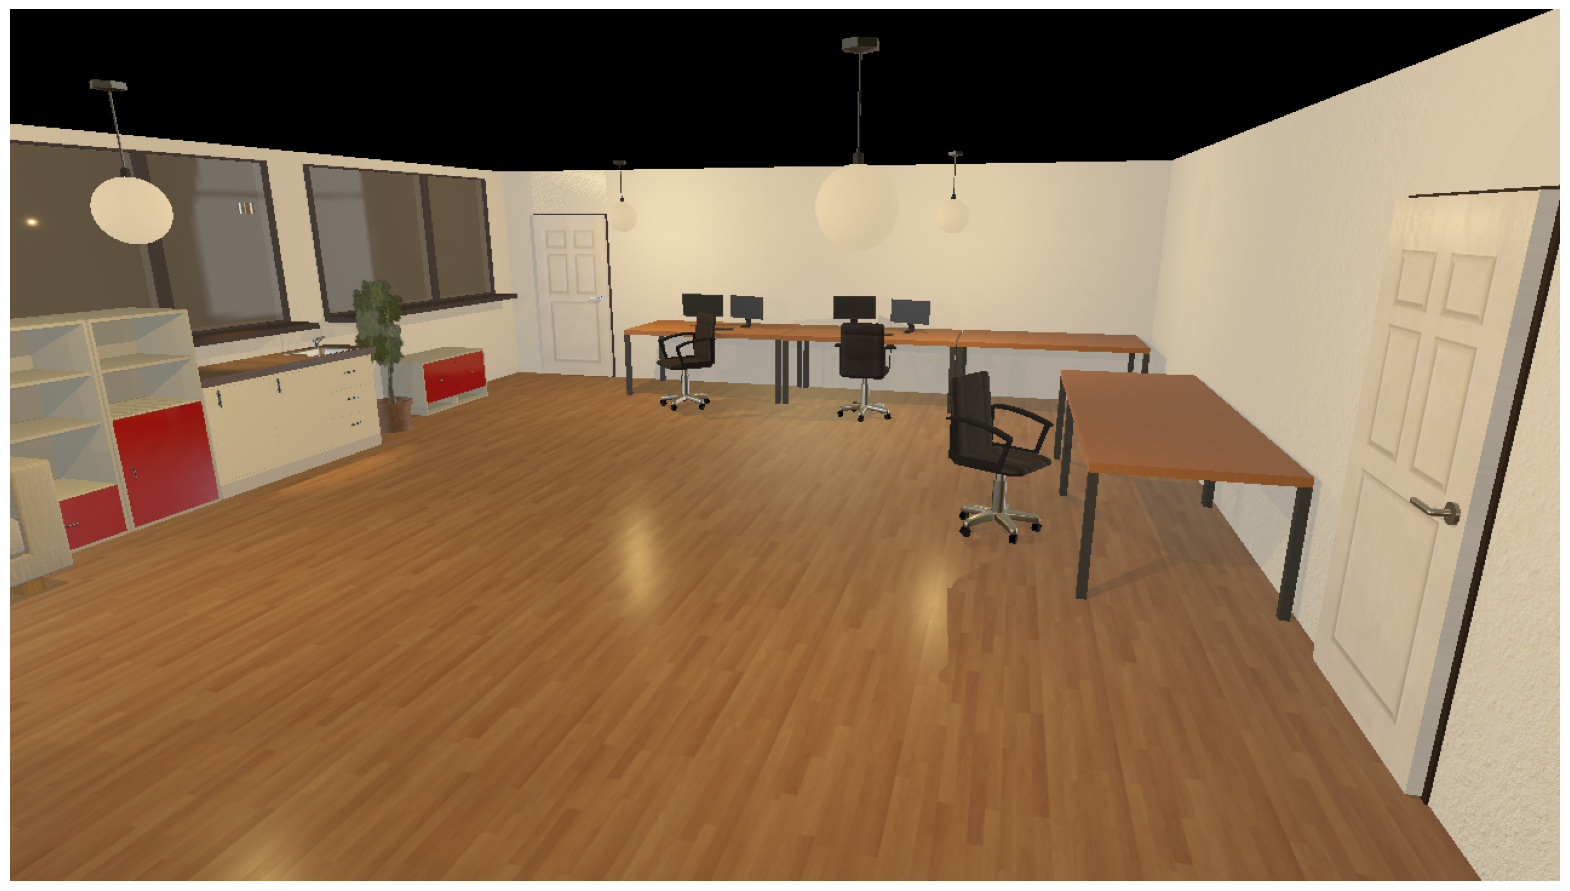

In [79]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


image = Image.open('/home/mahdlinux/ros2_ws/src/llm_search/llm_search/segment_test.png')
image = np.array(image.convert("RGB"))



plt.figure(figsize=(20, 20))
plt.imshow(image)
plt.axis('off')
plt.show()


In [80]:

sam2_checkpoint = "/home/mahdlinux/sam2/checkpoints/sam2.1_hiera_large.pt"
model_cfg = "configs/sam2.1/sam2.1_hiera_l"

sam2 = build_sam2(model_cfg, sam2_checkpoint, device=device, apply_postprocessing=False)

mask_generator = SAM2AutomaticMaskGenerator(sam2)

masks = mask_generator.generate(image)


print(len(masks))
print(masks[0].keys())

40
dict_keys(['segmentation', 'area', 'bbox', 'predicted_iou', 'point_coords', 'stability_score', 'crop_box'])


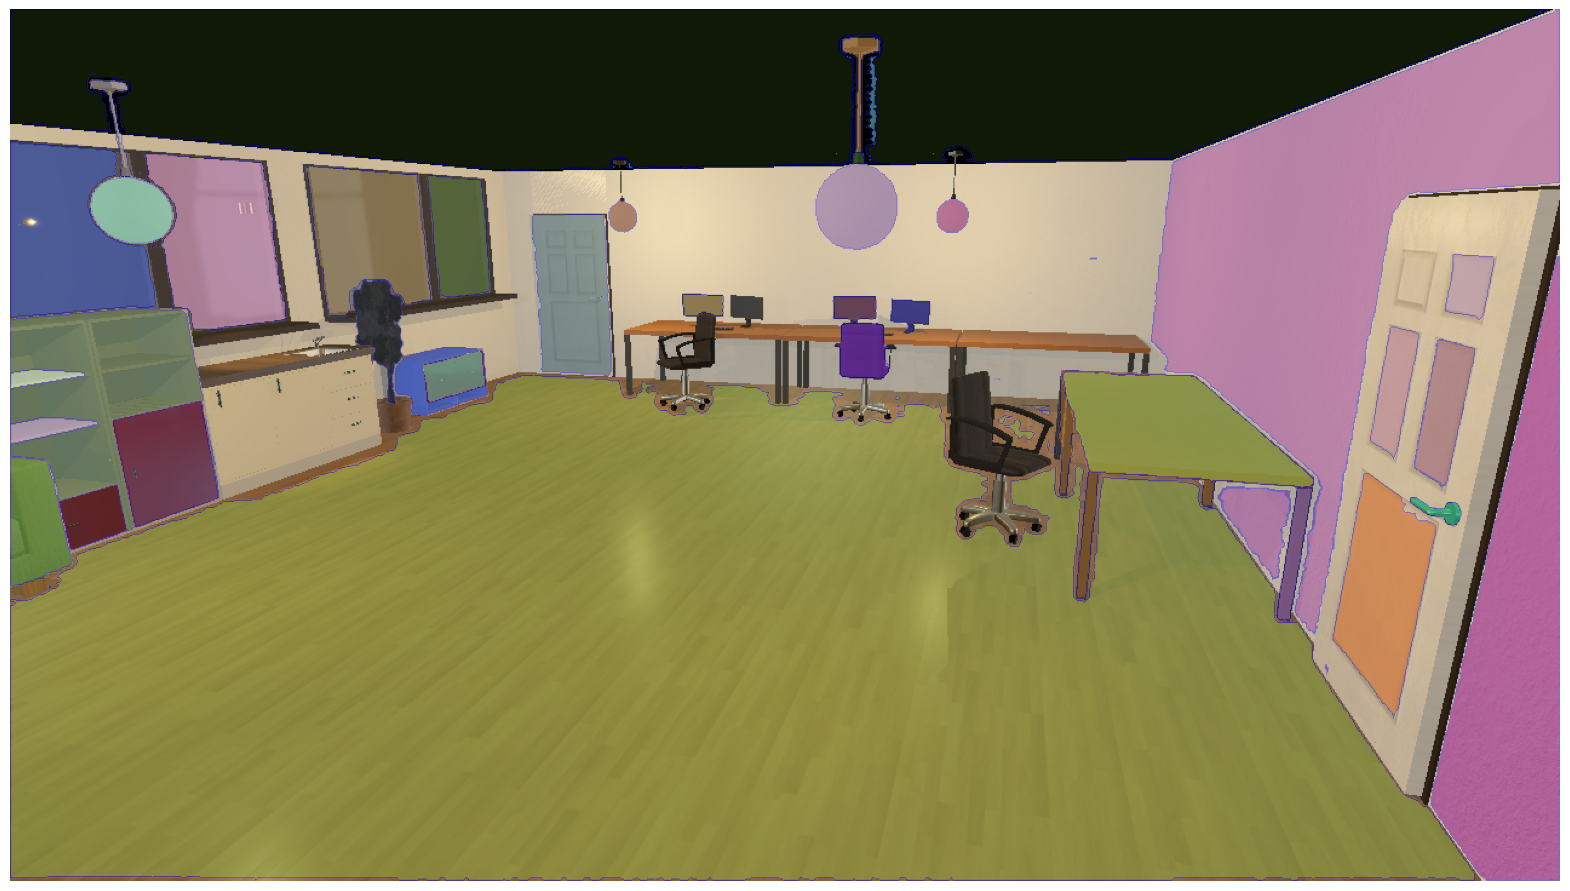

In [81]:
plt.figure(figsize=(20, 20))
plt.imshow(image)
show_anns(masks)
plt.axis('off')
plt.show() 

In [82]:
clip_model, clip_preprocess = clip.load("ViT-B/32", device=device)

In [83]:
# Encode text prompt
text = clip.tokenize(["floor"]).to(device)
with torch.no_grad():
    text_features = clip_model.encode_text(text)

In [84]:
# Step 4: For each mask, crop + encode
best_score = -1
best_mask = None


image_rgb = cv2.cvtColor(image, cv2.COLOR_RGBA2RGB)  # Convert to RGB if needed

for mask_info in masks:
    mask = mask_info["segmentation"].astype(np.uint8)  # bool to uint8

    # Apply mask to image
    masked = cv2.bitwise_and(image_rgb, image_rgb, mask=mask)

    # Crop to bbox (CLIP works better without large black borders)
    x, y, w, h = mask_info["bbox"]
    # Convert to integers for array slicing
    x, y, w, h = int(x), int(y), int(w), int(h)
    cropped = masked[y:y+h, x:x+w]
    if cropped.size == 0: continue

    # PIL Image for CLIP
    pil = Image.fromarray(cropped)
    image_input = clip_preprocess(pil).unsqueeze(0).to(device)

    # Encode image
    with torch.no_grad():
        image_features = clip_model.encode_image(image_input)
    
    # Compute cosine similarity
    similarity = (image_features @ text_features.T).item()
    
    if similarity > best_score:
        best_score = similarity
        best_mask = mask

print("Best matching mask score:", best_score)

Best matching mask score: 36.76722717285156


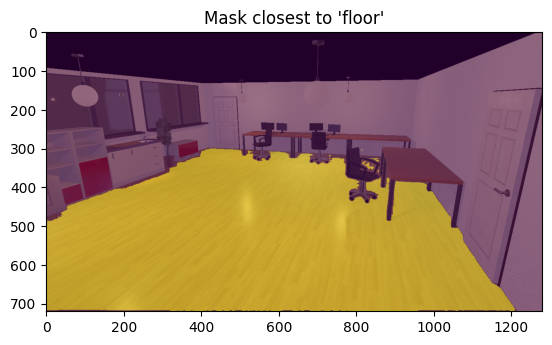

In [85]:
np.save('best_mask.npy', best_mask)

plt.imshow(image_rgb)
plt.imshow(best_mask, alpha=0.5)
plt.title("Mask closest to 'floor'")
plt.show()

In [86]:
# best_mask: binary mask from SAM+CLIP
contours, _ = cv2.findContours(best_mask.astype(np.uint8), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# Usually there is only 1 large contour, but you can pick the biggest
floor_contour = max(contours, key=cv2.contourArea)

In [87]:
epsilon = 0.01 * cv2.arcLength(floor_contour, True)
approx = cv2.approxPolyDP(floor_contour, epsilon, True)
# Convert polygon points to Nx2 numpy array
polygon = approx.reshape(-1, 2)


In [88]:
# bounding box
min_x, min_y = polygon.min(axis=0)
max_x, max_y = polygon.max(axis=0)

step = 115  # smaller step → denser grid → more triangles

grid_points = []
for y in range(min_y, max_y, step):
    for x in range(min_x, max_x, step):
        if cv2.pointPolygonTest(polygon, (x,y), False) >= 0:
            grid_points.append([x,y])

grid_points = np.array(grid_points)

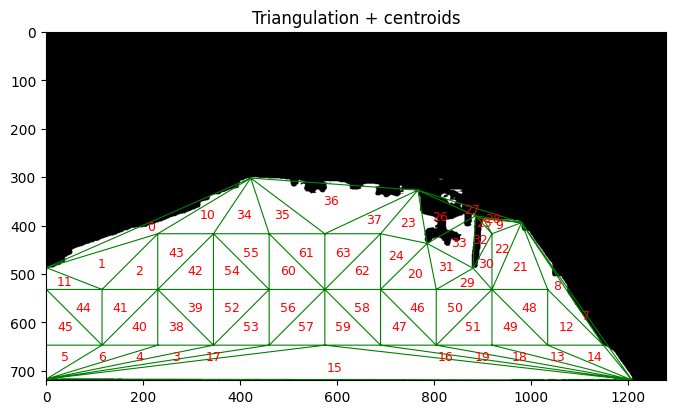

In [89]:
# Convert polygon points to Nx2 numpy array
all_points = np.vstack([polygon, grid_points])

# Perform Delaunay triangulation
tri = Delaunay(all_points)

triangle_centers = np.array([np.mean(all_points[simplex], axis=0) for simplex in tri.simplices])

# Visualize
# plt.figure(figsize=(6,6))
# plt.imshow(best_mask, cmap='gray')
# for simplex in tri.simplices:
#     pts = all_points[simplex]
#     plt.fill(pts[:,0], pts[:,1], edgecolor='red', fill=False, linewidth=1)
# plt.show()
plt.figure(figsize=(8,8))
plt.imshow(best_mask, cmap='gray')
plt.triplot(all_points[:,0], all_points[:,1], tri.simplices.copy(), color='green', lw=0.8)
# plt.scatter(triangle_centers[:,0], triangle_centers[:,1], color='red', s=10)
for i, center in enumerate(triangle_centers):
    plt.text(center[0], center[1], str(i), color='red', fontsize=9, ha='center', va='center')
plt.title('Triangulation + centroids')
plt.show()

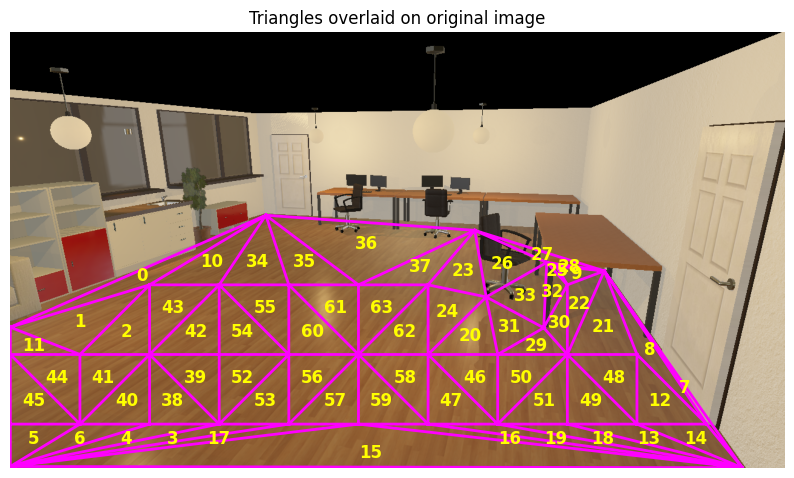

In [ ]:
plt.figure(figsize=(10, 10))
plt.imshow(image_rgb)
plt.triplot(all_points[:, 0], all_points[:, 1], tri.simplices.copy(), color='green', lw=0.8)
plt.title('Triangles overlaid on original image')
plt.axis('off')
# Overlay triangle numbers in bold yellow and use a bold color for triangle edges
for i, center in enumerate(triangle_centers):
    plt.text(center[0], center[1], str(i), color='yellow', fontsize=12, fontweight='bold', ha='center', va='center')
plt.triplot(all_points[:, 0], all_points[:, 1], tri.simplices.copy(), color='magenta', lw=2)

plt.show()


In [91]:
depth_array = np.load('test_depth.npy')
depth_array

array([[      inf,       inf,       inf, ..., 2.3960001, 2.411    ,
        2.38     ],
       [      inf,       inf,       inf, ..., 2.42     , 2.403    ,
        2.4050002],
       [      inf,       inf,       inf, ..., 2.403    , 2.414    ,
        2.411    ],
       ...,
       [2.483    , 2.4910002, 2.492    , ..., 2.1560001, 2.148    ,
        2.161    ],
       [2.489    , 2.4870002, 2.4910002, ..., 2.148    , 2.17     ,
        2.171    ],
       [2.48     , 2.489    , 2.483    , ..., 2.1820002, 2.17     ,
        2.1520002]], dtype=float32)

In [92]:
world_points = []
# valid_indices = []
for i, centroid in enumerate(triangle_centers):
    u, v = centroid
    depth = depth_array[int(v), int(u)]
    if np.isnan(depth) or depth <= 0 or depth > 10:  # Adjust threshold as needed
        continue  # Skip invalid depth values

    # The original deprojection assumed a standard CV camera frame (Z-fwd, X-right, Y-down).
    # However, many robotics systems and simulators use a different frame (X-fwd, Y-left, Z-up).
    # We'll convert the pixel coordinates into this robotics-standard frame.
    X_cam = depth
    Y_cam = -(u - cx) * depth / fx
    Z_cam = -(v - cy) * depth / fy
    P_camera = np.array([X_cam, Y_cam, Z_cam])

    # Convert axis-angle to rotation matrix
    axis = np.array([pib_pos.x_axis, pib_pos.y_axis, pib_pos.z_axis])
    angle = pib_pos.rotation
    r = R.from_rotvec(axis * angle)
    R_matrix = r.as_matrix()

    # Camera position in world coordinates
    T = np.array([pib_pos.x, pib_pos.y, pib_pos.z])

    # Transform point from camera to world coordinates
    P_world = R_matrix @ P_camera + T

    world_points.append(P_world)
    # valid_indices.append(i)


world_points = np.array(world_points)


world_points

array([[-1.14276484e+00, -1.71471374e+00,  5.21287581e-03],
       [ 2.81727870e-01, -1.07661872e+00, -4.82924104e-03],
       [ 3.27145977e-01, -4.05551288e-01, -5.39901322e-03],
       [ 1.51931674e+00,  1.26414769e+00, -5.61681058e-04],
       [ 1.60935553e+00,  9.83888704e-01,  1.12592793e-02],
       [ 1.75384964e+00,  3.75752030e-01, -3.33127215e-03],
       [ 1.68472196e+00,  6.86220803e-01,  7.78729688e-03],
       [ 7.80251665e-02,  4.69749995e+00,  4.72757473e-02],
       [-6.37186859e-01,  4.65858196e+00, -1.05575105e-02],
       [-2.83776387e+00,  4.30566025e+00,  6.44530199e-03],
       [-2.01156805e+00, -1.23484040e+00,  3.79509827e-03],
       [ 8.03203324e-01, -9.93303356e-01, -2.40597541e-03],
       [ 2.48606766e-01,  4.48714310e+00,  6.45746825e-03],
       [ 7.12962635e-01,  4.28594473e+00, -1.07342594e-03],
       [ 6.38100201e-01,  4.57844779e+00,  1.70727128e-03],
       [ 1.29681437e+00,  2.55675851e+00, -1.04701873e-02],
       [ 9.48719834e-01,  3.40282196e+00

In [93]:
import plotly.graph_objects as go

# Create a 3D scatter plot
fig = go.Figure(data=[go.Scatter3d(
    x=world_points[:, 0],
    y=world_points[:, 1],
    z=world_points[:, 2],
    mode='markers',
    marker=dict(
        size=4,
        opacity=0.8
    )
)])

# Add the camera position to the plot
fig.add_trace(go.Scatter3d(
    x=[pib_pos.x],
    y=[pib_pos.y],
    z=[pib_pos.z],
    mode='markers',
    marker=dict(
        size=8,
        color='red',
        symbol='diamond'
    ),
    name='Camera Position'
))


# Set plot layout
fig.update_layout(
    title='3D Visualization of World Points',
    scene=dict(
        xaxis_title='X World',
        yaxis_title='Y World',
        zaxis_title='Z World',
        aspectratio=dict(x=1, y=1, z=1)
    ),
    margin=dict(r=0, b=0, l=0, t=40)
)

fig.show()

In [94]:
class Node:
    def __init__(self, num, image_point, world_point):
        self.num = num
        self.image_point = image_point
        self.world_point = world_point
        self.adjacency = set()  # Use a set for unique neighbors
    
    def add_edge(self, other):
        """Create an edge between this node and another."""
        self.adjacency.add(other)
        other.adjacency.add(self)

    def __repr__(self):
        return f"Node({self.num}, {self.image_point}, {self.world_point})"

In [95]:
# Build an adjacency list for the triangle graph
adjacency_list = {i: Node(i, triangle_centers[i], tri.simplices[i]) for i in range(len(tri.simplices))}

# tri.neighbors[i, j] is the triangle adjacent to triangle i sharing an edge with vertex j.
# A value of -1 means no neighbor.
for i, neighbors in enumerate(tri.neighbors):
    for neighbor in neighbors:
        if neighbor != -1:
            adjacency_list[i].add_edge(adjacency_list[neighbor])

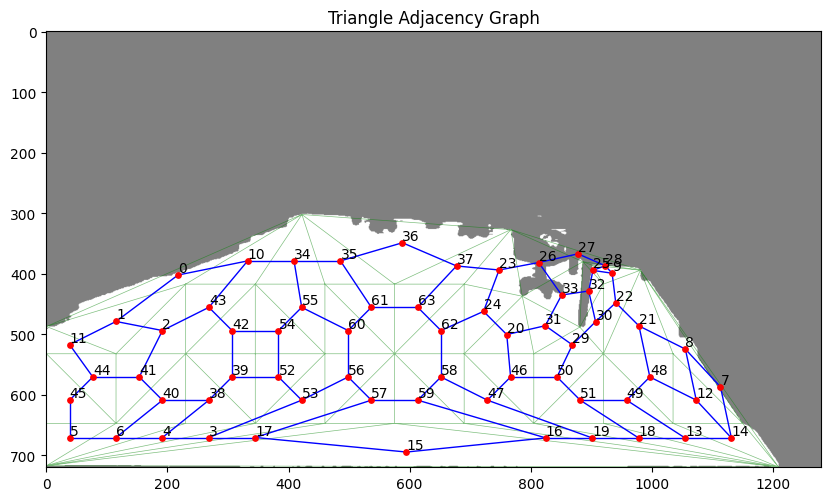

Triangle 0 is adjacent to triangles: [1, 10]
Triangle 1 is adjacent to triangles: [11, 0, 2]
Triangle 2 is adjacent to triangles: [1, 41, 43]
Triangle 3 is adjacent to triangles: [53, 17, 4]
Triangle 4 is adjacent to triangles: [3, 38, 6]


In [96]:
# Visualize the graph
plt.figure(figsize=(10,10))
plt.imshow(best_mask, cmap='gray', alpha=0.5)
plt.triplot(all_points[:,0], all_points[:,1], tri.simplices.copy(), color='green', lw=0.5, alpha=0.5)
plt.scatter(triangle_centers[:,0], triangle_centers[:,1], color='red', s=15, zorder=3)

# Draw lines between the centroids of adjacent triangles
for i, node in adjacency_list.items():
    neighbors = node.adjacency
    for neighbor in neighbors:
        # To avoid drawing lines twice, only draw from the smaller index to the larger
        if i < neighbor.num:
            p1 = triangle_centers[i]
            p2 = triangle_centers[neighbor.num]
            plt.plot([p1[0], p2[0]], [p1[1], p2[1]], 'b-', lw=1, zorder=2)
# Number the triangles at their centroid
for i, center in enumerate(triangle_centers):
    plt.text(center[0], center[1], str(i), color='black', fontsize=10, ha='left', va='bottom', zorder=4)

plt.title('Triangle Adjacency Graph')
plt.show()

# Print the first 5 entries of the adjacency list as an example
for i in range(min(5, len(adjacency_list))):
    print(f"Triangle {i} is adjacent to triangles: {[neighbor.num for neighbor in adjacency_list[i].adjacency]}")
